#Assignment 3x - EMNIST#


    Network has:
        6 Convolution layers with these kernels (10, 10, 20, 20, 30)
        no fully connected layer (have Global Average Pooling layer)
        uses EMNIST as the dataset
        uses a maximum of 2 max-pooling layers
    Code is:
        well documented
        Receptive field calculations mentioned (as we discussed in the class)
        Input and output size for each layer mentioned 
        Trained for minimum of 20 epochs on GPU

#Imports
Importing various dependencies for making, training, testing and visualising the model

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch.optim as optim
%matplotlib inline
!pip install torchsummary


#Model class
The model consists of 6 convolution layers, which will accept the input of a 28 x 28 single channel image. 3 x 3 kernels (10, 10, 20, 20, 30) , with stride of 1 are used for feature extraction. Max pooling layers are used for increasing the receptive field twice of the input. The input and the output size of each layers, along with the respective receptive fields. Summary of the model is stated below the model class. ReLU is used as the activation function of each layer, which introduces non linearity in each layer, while keeping the model architecture light-weight.

In [ ]:
class Net(nn.Module):
  def __init__(self):

    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, 3, padding = 1)
    # input 28 x 28 x 1 -- output 28 x 28 x 10, Receptive field - 3
    self.conv2 = nn.Conv2d(10, 10, 3, padding = 1)
    # input 28 x 28 x 10 -- output 28 x 28 x 10, Receptive field - 5
    self.pool1 = nn.MaxPool2d(2, 2) # Max Pooling layer with 2x2 kernel, stride of 2
    # input 28 x 28 x 10 -- output 14 x 14 x 10 - Receptive field - 10
    self.conv3 = nn.Conv2d(10, 20, 3, padding = 1)
    # input 14 x 14 x 10 -- output 14 x 14 x 20 - Receptive field - 12
    self.conv4 = nn.Conv2d(20, 20, 3, padding = 1)
    # input 14 x 14 x 20 -- output 14 x 14 x 20 - Receptive field - 14
    self.pool2 = nn.MaxPool2d(2, 2) # Max Pooling layer with 2x2 kernel, stride of 2
    # input 14 x 14 x 20 -- output 7 x 7 x 20 - Receptive field - 28
    self.conv5 = nn.Conv2d(20, 30, 3)
    # input 7 x 7 x 20 -- output 5 x 5 x 30 - Receptive fild - 30
    self.conv6 = nn.Conv2d(30, 26, 3)
    # input 5 x 5 x 30 -- output 3 x 3 x 26 - Receptive field - 32

  def forward(self, x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = self.conv6(F.relu(self.conv5(x)))
    x = F.avg_pool2d(x, 3)
    return F.log_softmax(x)

In [ ]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print(f'Device used : {device}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 20, 14, 14]           1,820
            Conv2d-5           [-1, 20, 14, 14]           3,620
         MaxPool2d-6             [-1, 20, 7, 7]               0
            Conv2d-7             [-1, 30, 5, 5]           5,430
            Conv2d-8             [-1, 26, 3, 3]           7,046
Total params: 18,926
Trainable params: 18,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.07
Estimated Total Size (MB): 0.28
----------------------------------------------------------------
Device used : cuda


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


#Dataset
We will be using EMNIST dataset for handwritten letter recognition, with "split" parameter set as "letters". The model will be fed with batch of 128 28x28 single channel images. For training the model, the training dataset is used which is set with auto_grad as true. For testing dataset, auto_grad is set to false. Each of the image in the dataset is Normalized with 0.1307 as the mean and 0.3081 as the standard deviation. The dataset is shuffled.

In [ ]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
dataset_train = datasets.EMNIST('../data', train = True, download = True, split = "letters",
                                transform = transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.1307,), (0.3081,))
                                ]))
# split (string): The dataset has 6 different splits: byclass, bymerge,
# balanced, letters, digits and mnist. This argument specifies
# which one to use.
dataset_test = datasets.EMNIST('../data', train = False, download = True,
                    transform = transforms.Compose([
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.1307,), (0.3081,))
                    ]), split = "letters")

train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True, **kwargs)


Extracting ../data/EMNIST/raw/emnist.zip to ../data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


#Visualising Dataset
Below is the piece of code for visualising the dataset by plotting the images in 5 (1x5) subplots. This gives a better understanding of what kind of dataset we are dealing with, along with their labels. The images are transposed for the sake of understanding and a better visualization.

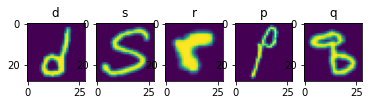

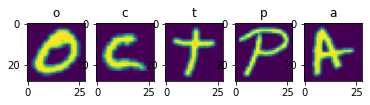

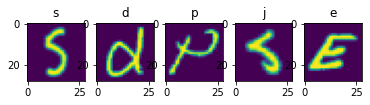

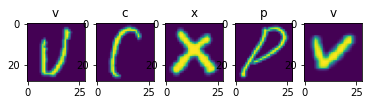

In [ ]:
images, labels = next(iter(train_loader))
i = 0
while i < 20:
  fig, ax = plt.subplots(1,5)
  for j in range(5):
    ax[j].imshow(torch.transpose(torch.squeeze(images[i]), 1, 0))
    ax[j].set_title(train_loader.dataset.classes[labels[i].item()-1])
    i += 1

#Training the model
The below code trains the model. 2 method definitions are present on the model, namely "train" and "test", which fulfill the needs accordingly. A progress bar is used in the training method to visualise the training phase of the model. 

Stochastic Gradient Descent is used as the optimizer of the model.


The negative log likelihood loss is used for calculating the loss of the model. It is useful to train a classification problem with `C` classes.
<br><br>
<img src = "https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png" width=500px height = 400px>

Fig: The loss function reaches infinity when input is 0, and reaches 0 when input is 1
<br>
<br>
The NLL loss can be better visualized by 
<br>
<img src = "https://i.imgur.com/hU252jE.jpg" width=500px height = 400px>


---
Using the above mentioned parameters, the model achieved 95% of testing accuracy

In [ ]:

#tqdm - progress bar
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader, position = 0, leave = True)
    correct=0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() 
        output = model(data)
        output = output.view(128, -1)
        target = target - 1

        #Read more about nll_loss
        loss = F.nll_loss(output, target)
        train_loss += loss
        #Read more about argmax
        pred = output.argmax(dim=1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader.dataset) 
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(train_loss, correct, len(train_loader.dataset),100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.view(128, -1)
            target = target - 1
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.28936493396759033 batch_id=974: 100%|██████████| 975/975 [00:32<00:00, 30.15it/s]


Train set: Average loss: 0.0017, Accuracy: 115739/124800 (93%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.2057, Accuracy: 116032/124800 (93%)



loss=0.273615300655365 batch_id=974: 100%|██████████| 975/975 [00:32<00:00, 30.29it/s]


Train set: Average loss: 0.0016, Accuracy: 116243/124800 (93%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1947, Accuracy: 116716/124800 (94%)



loss=0.11363527923822403 batch_id=974: 100%|██████████| 975/975 [00:31<00:00, 30.51it/s]


Train set: Average loss: 0.0015, Accuracy: 116628/124800 (93%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1867, Accuracy: 116944/124800 (94%)



loss=0.18731939792633057 batch_id=974: 100%|██████████| 975/975 [00:31<00:00, 31.15it/s]


Train set: Average loss: 0.0015, Accuracy: 116809/124800 (94%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1734, Accuracy: 117472/124800 (94%)



loss=0.19317641854286194 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.52it/s]



Train set: Average loss: 0.0014, Accuracy: 117067/124800 (94%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1693, Accuracy: 117553/124800 (94%)



loss=0.11645130813121796 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.53it/s]


Train set: Average loss: 0.0014, Accuracy: 117316/124800 (94%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1603, Accuracy: 117878/124800 (94%)



loss=0.11956001073122025 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.80it/s]


Train set: Average loss: 0.0013, Accuracy: 117461/124800 (94%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1634, Accuracy: 117755/124800 (94%)



loss=0.11725590378046036 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.58it/s]



Train set: Average loss: 0.0013, Accuracy: 117661/124800 (94%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1582, Accuracy: 118067/124800 (95%)



loss=0.10569695383310318 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.79it/s]


Train set: Average loss: 0.0013, Accuracy: 117820/124800 (94%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1751, Accuracy: 117097/124800 (94%)



loss=0.16849970817565918 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.63it/s]


Train set: Average loss: 0.0012, Accuracy: 117971/124800 (95%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1525, Accuracy: 118227/124800 (95%)



loss=0.30997881293296814 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.15it/s]



Train set: Average loss: 0.0012, Accuracy: 118022/124800 (95%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1494, Accuracy: 118389/124800 (95%)



loss=0.0875474214553833 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.13it/s]


Train set: Average loss: 0.0012, Accuracy: 118108/124800 (95%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1467, Accuracy: 118354/124800 (95%)



loss=0.14287839829921722 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.79it/s]



Train set: Average loss: 0.0012, Accuracy: 118150/124800 (95%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1410, Accuracy: 118564/124800 (95%)



loss=0.09916950017213821 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 31.88it/s]


Train set: Average loss: 0.0012, Accuracy: 118224/124800 (95%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1410, Accuracy: 118603/124800 (95%)



loss=0.12779533863067627 batch_id=974: 100%|██████████| 975/975 [00:29<00:00, 32.58it/s]



Train set: Average loss: 0.0012, Accuracy: 118272/124800 (95%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1348, Accuracy: 118911/124800 (95%)



loss=0.1997392475605011 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.32it/s]



Train set: Average loss: 0.0011, Accuracy: 118492/124800 (95%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1366, Accuracy: 118856/124800 (95%)



loss=0.10892272740602493 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.38it/s]


Train set: Average loss: 0.0011, Accuracy: 118518/124800 (95%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1306, Accuracy: 119093/124800 (95%)



loss=0.1313686966896057 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.31it/s]


Train set: Average loss: 0.0011, Accuracy: 118629/124800 (95%)




  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1296, Accuracy: 119163/124800 (95%)



loss=0.08625099062919617 batch_id=974: 100%|██████████| 975/975 [00:30<00:00, 32.46it/s]



Train set: Average loss: 0.0011, Accuracy: 118666/124800 (95%)



  0%|          | 0/975 [00:00<?, ?it/s]


Test set: Average loss: 0.1303, Accuracy: 119053/124800 (95%)



loss=0.15722665190696716 batch_id=974: 100%|██████████| 975/975 [00:29<00:00, 32.62it/s]



Train set: Average loss: 0.0011, Accuracy: 118715/124800 (95%)


Test set: Average loss: 0.1322, Accuracy: 119001/124800 (95%)

